#### GRUPO: aasj2; abl2; gbgv

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('glass.csv', index_col='id')

In [3]:
X = df.loc[:, [col for col in df if col != 'Type']]
y = df['Type']

# Análise Exploratória

In [4]:
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
id,,,,,,,,,,
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


### Medidas de tendência central

In [5]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


### Correlação

Podemos perceber através do mapa de calor abaixo que existe uma alta correlação entre o **índice de refração** e a quantidade de **calcio** presente, bem como uma correlação negativa entre **índice de refração** e **silício**, e entre **magnésio** e outros elementos como **alumínio**, **cálcio** e **bário**. O mais interessante porém é a alta correlação negativa entre o atributo de classe **Type** e o **magnésio**

<AxesSubplot:>

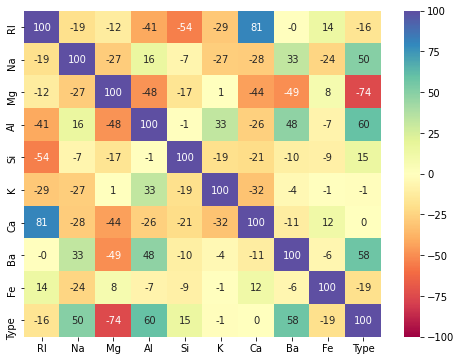

In [6]:
plt.subplots(figsize=(8, 6))
sns.heatmap(df.corr() * 100, annot=True, fmt=".0f", vmin=-100, vmax=100, cmap='Spectral')

# Pre-processamento

## Detecção de outliers

Pelo box plot abaixo é possível perceber a presença de vários outliers em cada atributo isoladamente

<AxesSubplot:>

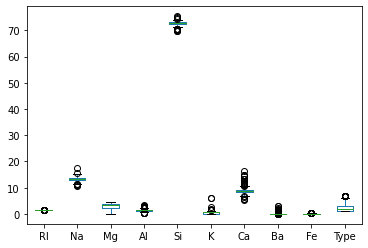

In [7]:
df.plot.box()

Na sequência é realizado o teste de shapiro para verificar se os atributos seguem uma curva normal e decidir qual algoritmo de detecção de outliers multivariado será utilizado


In [8]:
significance = .01
for col in X.columns:
    print(f'{col} is Gaussian: {stats.shapiro(df[col]).pvalue > significance}')

RI is Gaussian: False
Na is Gaussian: False
Mg is Gaussian: False
Al is Gaussian: False
Si is Gaussian: False
K is Gaussian: False
Ca is Gaussian: False
Ba is Gaussian: False
Fe is Gaussian: False


Como nenhum atributo se comportou como uma gaussiana, será utilizado o Isolation Forest, que é um teste não paramétrico.

In [9]:
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(random_state=0)

<AxesSubplot:>

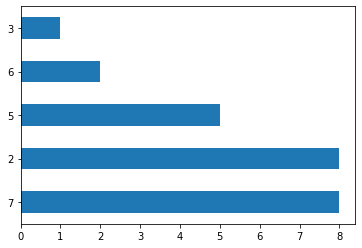

In [10]:
outliers = df[iforest.fit_predict(X) == -1]
outliers['Type'].value_counts().plot.barh()

<AxesSubplot:>

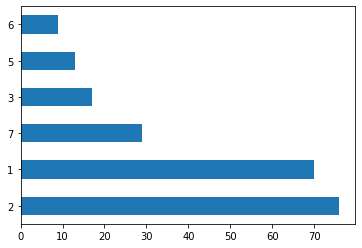

In [11]:
df['Type'].value_counts().plot.barh()

<AxesSubplot:>

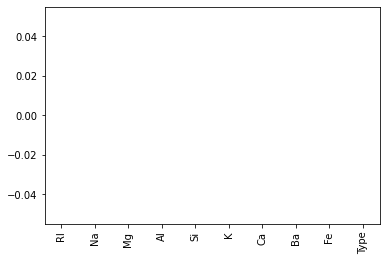

In [12]:
df.isna().sum().plot.bar()

Como a quantidade de outliers foi baixa e de duas classes predominantemente (2 e 7), optamos por não retirar nenhum dado; e como também não há instância com dados ausentes não precisamos imputar.

# SVM

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import f1_score, roc_auc_score

In [14]:
splits, repeats = 5, 10
rkf = RepeatedKFold(n_splits=splits, n_repeats=repeats, random_state=0)

In [15]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
polys = [i+1 for i in range(len(X.columns), len(X.columns) + 30)]

In [16]:
%%time

f1scores = dict()
auroc = dict()
for kernel in kernels:
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if kernel == 'poly':
            for d in polys:
                clf = SVC(kernel=kernel, degree=d)
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                f1scores[f'{kernel}_{d}'] = f1scores.get(f'{kernel}_{d}', 0) + f1_score(y_test, y_pred, average='micro')
                auroc[f'{kernel}_{d}'] = auroc.get(f'{kernel}_{d}', 0) + roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), multi_class='ovo')
        else:
            clf = SVC(kernel=kernel)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            f1scores[kernel] = f1scores.get(kernel, 0) + f1_score(y_test, y_pred, average='micro')
            auroc[kernel] = auroc.get(kernel, 0) + roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), multi_class='ovo')
            
for k in f1scores:
    f1scores[k] /= splits * repeats
    auroc[k] /= splits * repeats
    if k == 'poly':
        f1scores[k] /= len(polys)
        auroc[k] /= len(polys)

CPU times: user 34 s, sys: 2.93 ms, total: 34 s
Wall time: 34 s


<AxesSubplot:>

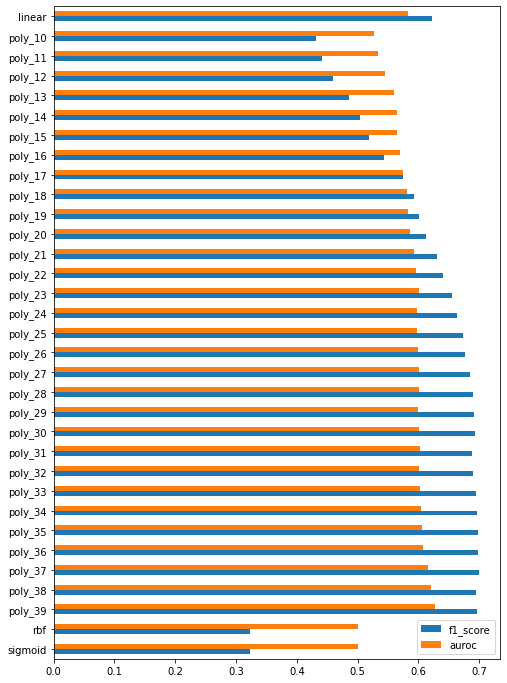

In [17]:
svm_metrics = pd.DataFrame(data=[f1scores, auroc]).T.sort_index(ascending=False)
svm_metrics.columns = ['f1_score', 'auroc']
svm_metrics.plot.barh(figsize=(8, 12))

É possível concluir de acordo com os F-scores acima que os kernels linear e polinomial obtiveram um melhor resultado comparado com os demais. Apesar de o linear ser o kernel mais simples, isso pode se dar pelo fato de a classe ter uma alta correlação negativa com um atributo especificamente, entre outras correlações relevantes com certos atributos, o que torna essa divisão no hiperplano um pouco melhor. É possível notar também a melhoria do desempenho do kernel polinomial a medida que é aumentado o grau até a casa dos 30 

# Neural Network

Definindo os hiperparametros

- o numero maximo de camadas foi definido como 2, devido a pouca quantidade de atributos e dados, não achamos necessário mais que isso.

- o numero de neuronios por camada varia de 50 em 50 no intervalo [100, 250]

- a taxa de aprendizagem $\alpha$ assume valores de {10e-4, 10e-3, 10e-2, 10e-1, 1}

- e o maximo de épocas foi definido como $10^4$ para que o algoritmo consiga convergir

In [18]:
NUM_CAMADAS = 2
NUM_NEURONS = 250
STEP_NEURONS = 50
hyper_params = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'hidden_layer_sizes': [tuple(n for i in range(c+1)) for n in range(100, NUM_NEURONS+1, STEP_NEURONS) for c in range(NUM_CAMADAS)],
    'alpha': [1/10**i for i in range(5)],
    'max_iter': [10000],
    'random_state': [0]
}
hyper_params

{'activation': ['identity', 'logistic', 'tanh', 'relu'],
 'hidden_layer_sizes': [(100,),
  (100, 100),
  (150,),
  (150, 150),
  (200,),
  (200, 200),
  (250,),
  (250, 250)],
 'alpha': [1.0, 0.1, 0.01, 0.001, 0.0001],
 'max_iter': [10000],
 'random_state': [0]}

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [20]:
mlp = MLPClassifier()
grid_search = GridSearchCV(mlp, hyper_params, cv=5, n_jobs=-1,
                           scoring=['f1_micro', 'roc_auc_ovo'], refit=False)

O treino dos algoritmos será realizado usando o grid search do sklearn

In [21]:
%%time

grid_search.fit(X, y)

CPU times: user 2.42 s, sys: 195 ms, total: 2.61 s
Wall time: 3min 10s


GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': [1.0, 0.1, 0.01, 0.001, 0.0001],
                         'hidden_layer_sizes': [(100,), (100, 100), (150,),
                                                (150, 150), (200,), (200, 200),
                                                (250,), (250, 250)],
                         'max_iter': [10000], 'random_state': [0]},
             refit=False, scoring=['f1_micro', 'roc_auc_ovo'])

In [22]:
nn_results = pd.DataFrame(grid_search.cv_results_)
metrics_cols = [col for col in nn_results.columns if col.startswith('mean_test')]
nn_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_max_iter,param_random_state,params,...,std_test_f1_micro,rank_test_f1_micro,split0_test_roc_auc_ovo,split1_test_roc_auc_ovo,split2_test_roc_auc_ovo,split3_test_roc_auc_ovo,split4_test_roc_auc_ovo,mean_test_roc_auc_ovo,std_test_roc_auc_ovo,rank_test_roc_auc_ovo
0,0.038884,0.007711,0.038626,0.001758,identity,1,"(100,)",10000,0,"{'activation': 'identity', 'alpha': 1.0, 'hidd...",...,0.009062,122,0.605093,0.658161,0.577963,0.663069,0.591048,0.619067,0.035027,150
1,0.703773,0.500854,0.041836,0.002274,identity,1,"(100, 100)",10000,0,"{'activation': 'identity', 'alpha': 1.0, 'hidd...",...,0.160552,95,0.575810,0.853532,0.684921,0.925820,0.913333,0.790683,0.137558,95
2,1.443345,0.073903,0.047039,0.002705,identity,1,"(150,)",10000,0,"{'activation': 'identity', 'alpha': 1.0, 'hidd...",...,0.069785,43,0.814649,0.870873,0.801825,0.922434,0.908730,0.863702,0.048504,73
3,0.075247,0.016195,0.049967,0.009522,identity,1,"(150, 150)",10000,0,"{'activation': 'identity', 'alpha': 1.0, 'hidd...",...,0.052609,150,0.539633,0.594206,0.576574,0.538995,0.458243,0.541530,0.046797,157
4,0.067541,0.008480,0.045701,0.008603,identity,1,"(200,)",10000,0,"{'activation': 'identity', 'alpha': 1.0, 'hidd...",...,0.048514,156,0.559474,0.619709,0.627222,0.584550,0.573757,0.592942,0.026269,155


<AxesSubplot:>

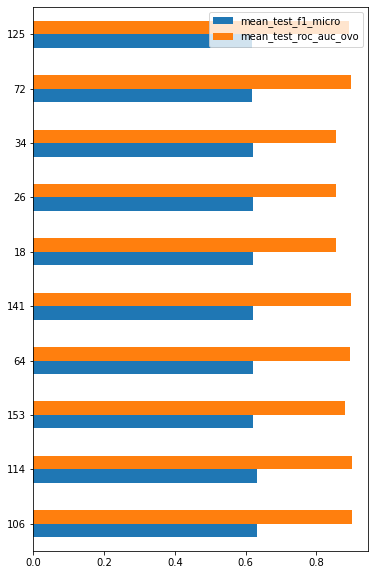

In [23]:
best_classifiers = nn_results.nlargest(10, columns=metrics_cols)
best_classifiers[metrics_cols].plot.barh(figsize=(6, 10))

In [24]:
nn_metrics = best_classifiers.copy()[metrics_cols]
nn_metrics.columns = ['f1_score', 'auroc']

Comparação com o SVM

Melhores 30 F-score entre os 2 algoritmos

<AxesSubplot:>

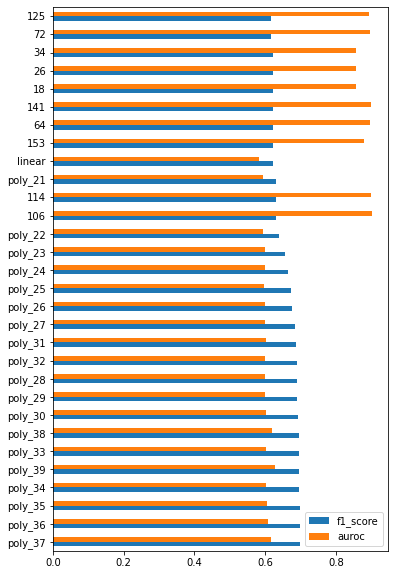

In [30]:
svm_metrics.append(nn_metrics).nlargest(30, columns=['f1_score']).plot.barh(figsize=(6, 10))

Podemos perceber que as Redes Neurais obtiveram uma área sob a curva ROC consideravelmente maior que os outros SVM, mas um F-score menor. Isso pode ser causado por um **alto número de falsos positivos** nas redes neurais.

Para esse dataset o SVM resolve melhor o problema de classificação

Abaixo estão os hiper-parametros que obtiveram melhor F-score nas redes neurais:
- Função de ativação: tangente hiperbolica
- $\alpha$ = {10e-3, 10e-4}
- 1 camada de 150 neurons

In [31]:
list(nn_results[nn_results['rank_test_f1_micro'] == 1]['params'])

[{'activation': 'tanh',
  'alpha': 0.001,
  'hidden_layer_sizes': (150,),
  'max_iter': 10000,
  'random_state': 0},
 {'activation': 'tanh',
  'alpha': 0.0001,
  'hidden_layer_sizes': (150,),
  'max_iter': 10000,
  'random_state': 0}]